In [467]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from itertools import accumulate
import gpxpy
from geopy import distance
from math import sqrt, floor
#import plotly.plotly as py
#import plotly.graph_objs as go
import haversine
import folium

In [494]:
#import files and set dates
#gpx of full walk, broken into segments, with some extra alternative routes
gpx_file = open('Wainwrights-Coast-to-Coast-SWC-Walk-L7.gpx', 'r')
#csv of 'Date' Vs. 'Distance' in km
df_input = pd.read_csv('Virtual C2C 2021.csv')
df_input['cum_distance'] = df_input['Distance'].cumsum()
df_input['Date']=pd.to_datetime(df_input['Date'])
df_input['day']=[abs((day - first_day).days)+1 for day in df_input['Date']]

#general date handling and useful values
first_day = datetime.datetime(2021, 1, 1)
last_day = datetime.datetime(2021, 1, 31)
today = datetime.datetime.today()
dates = pd.date_range(start=first_day, end=today).tolist()
current_days = abs((today - first_day).days)+1
current_distance = df_input['Distance'].fillna(0).sum()
#print(current_distance)
print(current_days)

23


In [475]:
#parsing of .gpx
#https://pypi.org/project/gpxpy/

gpx = gpxpy.parse(gpx_file)
gpx.waypoints
gpx.routes


#iterate through route, extract values from list of points and segment name from route name
df_gpx = pd.DataFrame({"segment":[], "Latitude":[], "Longitude":[], "elevation":[]})
for route in gpx.routes:
    longitudes=[o.longitude for o in route.points]
    latitudes=[o.latitude for o in route.points]
    elevations=[o.elevation for o in route.points]
    segment = [route.name]*len(longitudes)
    df_gpx = df_gpx.append(pd.DataFrame({"segment":segment,
                                 "Latitude":latitudes,
                                 "Longitude":longitudes,
                                 "elevation":elevations}), ignore_index=True)
df_gpx['points'] = list(zip(df_gpx.Latitude, df_gpx.Longitude))

#filter out extra routes
df_full = df_gpx
df_days = df_gpx[df_gpx['segment'].str.startswith('Day ')]
df_extra = df_gpx[df_gpx['segment'].str.startswith('Day ')==False]

#create list of waymarkers for segments (could be extracted instead from gpx.Waypoints)
waymarkers = ['St. Bees']
for segment in df_days['segment'].unique():
    waymarkers.append(re.sub('Day [0-9]* [a-zA-Z ]* to ', '', segment))

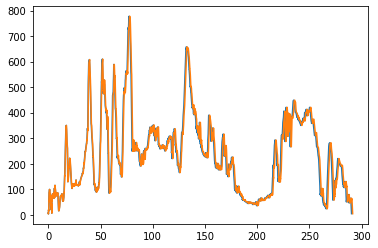

In [476]:
#calculate distances and whether they've been completed
#turn off false warning for chained assignment of .loc
pd.options.mode.chained_assignment = None  # default='warn'


alt_dif = [0]
time_dif = [0]
dist_hav = [0]
dist_hav_no_alt = [0]
dist_dif_hav_2d = [0]
dist_completed = [True]
for index in range(len(df_days)):
    if index == 0:
        pass
    else:
        start = df_days.loc[index-1,:]
        stop = df_days.loc[index,:]
        distance_hav_2d = haversine.haversine((start.Latitude, start.Longitude), (stop.Latitude, stop.Longitude))*1000
        dist_dif_hav_2d.append(distance_hav_2d) 
        dist_hav_no_alt.append(dist_hav_no_alt[-1] + distance_hav_2d)       
        alt_d = start.elevation - stop.elevation
        alt_dif.append(alt_d)
        distance_hav_3d = sqrt(distance_hav_2d**2 + (alt_d)**2)       
        dist_hav.append(dist_hav[-1] + distance_hav_3d)
        if dist_hav[-1] <= current_distance*1000:
            dist_completed.append(True)
        else:
            dist_completed.append(False)
        
df_days['dist_hav_2d'] = [x / 1000 for x in dist_hav_no_alt]
df_days['dist_hav_3d'] = [x / 1000 for x in dist_hav]
df_days['alt_dif'] = alt_dif
df_days['dist_dif_hav_2d'] = [x / 1000 for x in dist_dif_hav_2d]
df_days['dist_completed'] = dist_completed


cumsum_segment = [0]
for i_segment in df_days['segment'].unique():
    seg_dist = list(df_days[df_days['segment'].str.contains(i_segment)].dist_hav_2d)
    cumsum_segment.append(max(seg_dist))

#df = pd.DataFrame({'date' : dates, 'distance' : distances, 'total distance' : np.cumsum(distances)})
final_distance = max(cumsum_segment)    


#plt.plot(df_days['dist_hav_2d'], df_days['elevation'])
#plt.plot(df_days['dist_hav_3d'], df_days['elevation'])
pd.options.mode.chained_assignment = 'warn'  # default='warn'


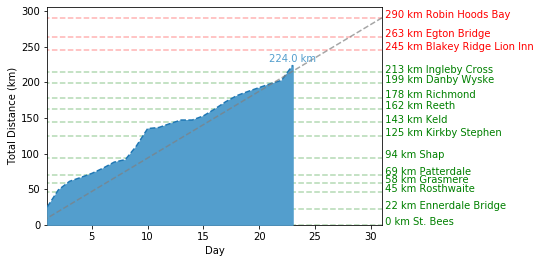

In [578]:
#generate plot
#create and label
plt.plot(df_input['day'], df_input['cum_distance'], '--', zorder=98)
plt.xlabel('Day')
plt.ylabel('Total Distance (km)')
#plt.xticks(rotation=-45, ha='left')
plt.fill_between(df_input['day'], df_input['cum_distance'],
                 color='#539ecd', zorder=97)
plt.xlim(1, max(df_input['day']))
plt.ylim(0, 305)
# #lines
# # plt.plot([first_day, last_day], [final_distance, final_distance], 'k--', color='red')
plt.plot([0, max(df_input['day'])], [0, final_distance], 'k--', color='grey', alpha=0.7, zorder=99)
# # plt.text(last_day,final_distance,' 293 km Robin Hoods Bay', color='red')
plt.text(current_days,current_distance+5,
        str(round(current_distance, 1)) + ' km',
        color='#539ecd', zorder=100,
        horizontalalignment='center')

#more lines
for i_seg in range(len(cumsum_segment)):
    if current_distance >= cumsum_segment[i_seg]:
        complete = 'green'
    else:
        complete = 'red'
    plt.plot([0, max(df_input['day'])], [cumsum_segment[i_seg], cumsum_segment[i_seg]],
             'k--', color=complete, alpha = 0.3)
    plt.text(max(df_input['day']),cumsum_segment[i_seg],
         ' '+str(int(cumsum_segment[i_seg]))+' km '+waymarkers[i_seg],
         color=complete)
    #fig.tight_layout()
    plt.savefig('progress.png', dpi=200, bbox_inches="tight") 



In [589]:
#create map
mymap = folium.Map( location=[ df.Latitude.mean(), df.Longitude.mean() ], zoom_start=8, tiles=None)
folium.TileLayer('openstreetmap', name='OpenStreet Map').add_to(mymap)
folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC', name='Nat Geo Map').add_to(mymap)
folium.TileLayer('http://tile.stamen.com/terrain/{z}/{x}/{y}.jpg', attr='terrain-bcg', name='Terrain Map').add_to(mymap)

#create lines colored by complete
points = list(df_days[df_days['dist_completed']==True].points)
folium.PolyLine(points, color='green', weight=4.5, opacity=.5).add_to(mymap)
points = list(df_days[df_days['dist_completed']==False].points)
folium.PolyLine(points, color='red', weight=4.5, opacity=.5).add_to(mymap)

#add progress marker
prog_message=('Days: '+str(current_days)+
              ' Progress: '+str(round(current_distance, 1))+' km'+
              ', Remaining: '+str(round(final_distance-current_distance, 1))+' km')
pophtml = folium.Html('<b>'+prog_message+'</b><img src="progress.png" width=400 height=200>', script=True)
folium.Marker(
    location=list(df_days[df_days['dist_completed']==True].points)[-1],
    popup=folium.Popup(pophtml, max_width=400, max_height=250),
    icon=folium.Icon(icon="cloud"),
).add_to(mymap)

#add waypoint markers
folium.Marker(
    location=df_days.points[0],
    popup=waymarkers[0],
    icon=folium.Icon(icon="cloud", color='green'),
).add_to(mymap)
segments = df_days['segment'].unique()
for i_way in range(1, len(waymarkers)):
    if current_distance >= cumsum_segment[i_way]:
        complete = 'green'
    else:
        complete = 'red'
    segment = segments[i_way-1]
    seg_points = list(df_days[df_days['segment'].str.contains(segment)].points)
    folium.Marker(
        location=seg_points[-1],
        popup=waymarkers[i_way],
        icon=folium.Icon(icon="info-sign", color=complete),
    ).add_to(mymap)

#img = ('progress.png')
#image = (img, bottom = 40,left =65).add_to(mymap)

mymap